# Data Preparation

In [442]:
import numpy as np
import pandas as pd
import pickle
from math import ceil

In [443]:
from utils.files import file_list, read_lat_lon

path = "../VED_DynamicData"

num_files, data_files = file_list(path)
print("In total: {} files".format(num_files))

In total: 54 files


In [444]:
def updated_lat_lon_range(n_lat_range, n_lon_range, o_lat_range, o_lon_range):
    lat_range = (min(o_lat_range[0], n_lat_range[0]), max(o_lat_range[1], n_lat_range[1]))
    lon_range = (min(o_lon_range[0], n_lon_range[0]), max(o_lon_range[1], n_lon_range[1]))
    return lat_range, lon_range

In [445]:
try:
    range_file = open('./cached_vars/range_file', 'rb')
    lat_range, lon_range = pickle.load(range_file)
    range_file.close()
except:
    lat_range = (999, -999)
    lon_range = (999, -999)

    for file in data_files:
        n_lat_range, n_lon_range, _, _ = read_lat_lon(path+'/'+file)
        lat_range, lon_range = updated_lat_lon_range(n_lat_range, n_lon_range, lat_range, lon_range)
    range_file = open('./cached_vars/range_file', 'wb')
    pickle.dump((lat_range, lon_range), range_file)
    range_file.close()

In [446]:
lat_diff = lat_range[1] - lat_range[0]
lon_diff = lon_range[1] - lon_range[0]

print("Latitude range [deg]: {}, Difference: {}".format(lat_range, lat_diff))
print("Longtitude range [deg]: {}, Difference: {}".format(lon_range, lon_diff))

Latitude range [deg]: (42.2203052778, 42.3258), Difference: 0.10549472219999956
Longtitude range [deg]: (-83.8042902778, -83.674), Difference: 0.13029027780000035


In [447]:
from utils.geography import cal_edges
grid_dist = 1000 # in meters
xedges, yedges = cal_edges(lat_range, lon_range, grid_dist)
filename = './cached_vars/heatmap_file' + str(grid_dist)
try:
    heatmap_file = open(filename, 'rb')
    g_d, heatmap = pickle.load(heatmap_file)
    heatmap_file.close()
    if grid_dist != g_d:
        raise Exception('grid density changed...')
except:
    heatmap = np.zeros((len(xedges)-1, len(yedges)-1))
    for file in data_files:
        _, _, lat, lon = read_lat_lon(path+'/'+file)
        H, _, _ = np.histogram2d(lat, lon, bins=(xedges, yedges))
        heatmap += H
    heatmap_file = open(filename, 'wb')
    pickle.dump((grid_dist, heatmap), heatmap_file)
    heatmap_file.close()

In [448]:
heatmap = pd.DataFrame(heatmap)
heatmap.index = [round(i,4) for i in xedges[1:]]
heatmap.columns = [round(i,4) for i in yedges[1:]]
heatmap.index.name = 'Longitude'
heatmap.columns.name = 'Latitude'

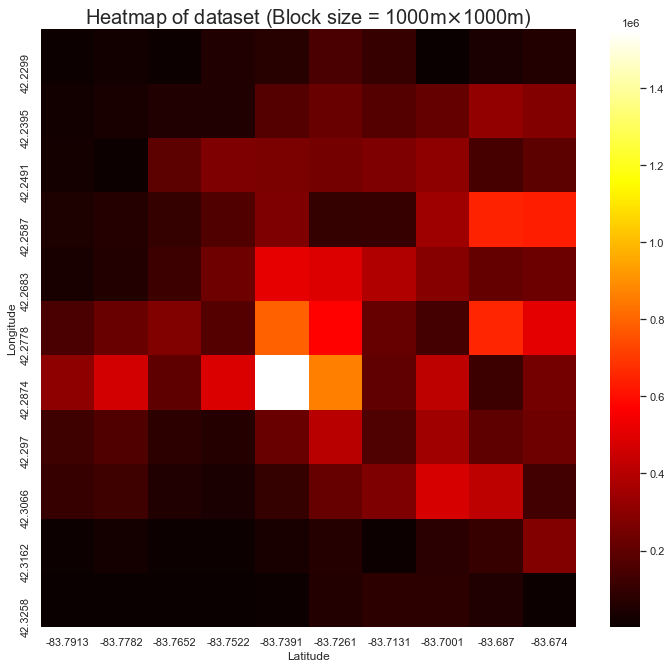

In [449]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

plt.figure(figsize=(12,11))
ax = sns.heatmap(heatmap, cmap='hot')
plt.title(r"Heatmap of dataset (Block size = {}m$\times${}m)".format(grid_dist, grid_dist), fontsize=20)
plt.savefig("./images/heatmap_{}.jpg".format(grid_dist))
plt.show()